

# Overview of MEG/EEG analysis with MNE-Python

This tutorial covers the basic EEG/MEG pipeline for event-related analysis: loading
data, epoching, averaging, plotting, and estimating cortical activity from sensor data.
It introduces the core MNE-Python data structures `~mne.io.Raw`, `~mne.Epochs`,
`~mne.Evoked`, and `~mne.SourceEstimate`, and covers a lot of ground fairly quickly (at
the expense of depth). Subsequent tutorials address each of these topics in greater
detail.

We begin by importing the necessary Python modules:


In [ ]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:
import numpy as np

import mne

In [1]:
!pwd

/EEG_tut


## Loading data

MNE-Python data structures are based around the FIF file format from
Neuromag, but there are reader functions for `a wide variety of other
data formats <data-formats>`. MNE-Python also has interfaces to a
variety of `publicly available datasets <datasets>`, which MNE-Python
can download and manage for you.

We'll start this tutorial by loading one of the example datasets (called
"`sample-dataset`"), which contains EEG and MEG data from one subject
performing an audiovisual experiment, along with structural MRI scans for
that subject. The `mne.datasets.sample.data_path` function will automatically
download the dataset if it isn't found in one of the expected locations, then
return the directory path to the dataset (see the documentation of
`~mne.datasets.sample.data_path` for a list of places it checks before
downloading). Note also that for this tutorial to run smoothly on our
servers, we're using a filtered and downsampled version of the data
(:file:`sample_audvis_filt-0-40_raw.fif`), but an unfiltered version
(:file:`sample_audvis_raw.fif`) is also included in the sample dataset and
could be substituted here when running the tutorial locally.



In [4]:
sample_data_folder = mne.datasets.sample.data_path(path="/EEG_tut")
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=True)

100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.28TB/s]
Untarring contents of '/EEG_tut/MNE-sample-data-processed.tar.gz' to '/EEG_tut'


Download complete in 01m19s (1576.2 MB)
Opening raw data file /EEG_tut/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


By default, `~mne.io.read_raw_fif` displays some information about the file
it's loading; for example, here it tells us that there are four "projection
items" in the file along with the recorded data; those are :term:`SSP
projectors <projector>` calculated to remove environmental noise from the MEG
signals, plus a projector to mean-reference the EEG channels; these are
discussed in the tutorial `tut-projectors-background`. In addition to
the information displayed during loading, you can get a glimpse of the basic
details of a `~mne.io.Raw` object by printing it; even more is available by
printing its ``info`` attribute (a `dictionary-like object <mne.Info>` that
is preserved across `~mne.io.Raw`, `~mne.Epochs`, and `~mne.Evoked` objects).
The ``info`` data structure keeps track of channel locations, applied
filters, projectors, etc. Notice especially the ``chs`` entry, showing that
MNE-Python detects different sensor types and handles each appropriately. See
`tut-info-class` for more on the `~mne.Info` class.



In [5]:
print(raw)
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.2 MB, data not loaded>
<Info | 14 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


- Raw: Indicates that the file sample_audvis_filt-0-40_raw.fif is a raw dataset, usually meaning the data hasn't been processed or cleaned. .fif is a file format often used in MEG/EEG studies.
- 376 x 41700 (277.7 s): The dataset contains 376 channels and 41,700 time points, covering 277.7 seconds of recorded data. The size of the file is approximately 3.2 MB, and the data is not currently loaded into memory.
- bads: Lists bad channels that may be noisy or not functioning correctly. Here, one MEG and one EEG sensor are marked as bad.
- ch_names: Names of the channels included in the recording. The list is truncated but includes MEG and EEG sensor names.
- chs: Specifies the types and counts of channels recorded: 204 gradiometers (sensors that measure magnetic field gradients), 102 magnetometers (sensors that measure the magnetic field), 9 stimulus channels (likely for event markers), 60 EEG channels, and 1 EOG (electrooculography) channel for eye movement.
- custom_ref_applied: Indicates whether a custom reference has been applied to the EEG data. False means no custom reference was used.
- dev_head_t: Describes the transform between the MEG device coordinate system and the head coordinate system, ensuring that the data is correctly aligned with the anatomy of the subject's head.
- dig: Digitization points include positions of sensors and fiducial markers on the subject's head (3 Cardinal points for alignment, 4 HPI for head position indicators, 61 EEG sensors, and 78 extra points that might be head shape points).
- highpass: The highpass filter cutoff frequency is set at 0.1 Hz, indicating that frequencies below 0.1 Hz are filtered out.
- hpi_meas, hpi_results: Information about head position indicator measurements and results, used to track the head position during the MEG recording.
- lowpass: The lowpass filter cutoff frequency is set at 40.0 Hz, indicating that frequencies above 40.0 Hz are filtered out.
- meas_date: The date and time the measurement was taken, which is December 3, 2002, at 19:01:10 UTC.
- meas_id: An identifier for the measurement session, typically unique to the dataset.
- nchan: The total number of channels in the dataset, which is 376.
- projs: Indicates the status of SSP (signal space projection) vectors used for noise reduction. PCA (Principal Component Analysis) vectors are turned off, as is the average EEG reference projection.
- sfreq: The sampling frequency of the recording is 150.2 Hz, which is the rate at which data points are recorded from each channel.

`~mne.io.Raw` objects also have several built-in plotting methods; here we
show the power spectral density (PSD) for each sensor type with
`~mne.io.Raw.compute_psd`, as well as a plot of the raw sensor traces with
`~mne.io.Raw.plot`. In the PSD plot, we'll only plot frequencies below 50 Hz
(since our data are low-pass filtered at 40 Hz). In interactive Python
sessions, `~mne.io.Raw.plot` is interactive and allows scrolling, scaling,
bad channel marking, annotations, projector toggling, etc.
- Frequency Distribution: PSD shows how much power of a signal lies within each frequency band over a range of frequencies. It can be used to identify dominant frequencies or periodicities in the data.
- Square of Amplitude: The power in this context is proportional to the square of the amplitude of the signal at each frequency. Therefore, the PSD is typically expressed in units such as watts per hertz (W/Hz) or decibels per hertz (dB/Hz).
- Fourier Transform: PSD is often calculated using the Fourier Transform, which converts the time-domain signal into its frequency components. The square of the absolute value of the Fourier Transform gives the power spectrum.


Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


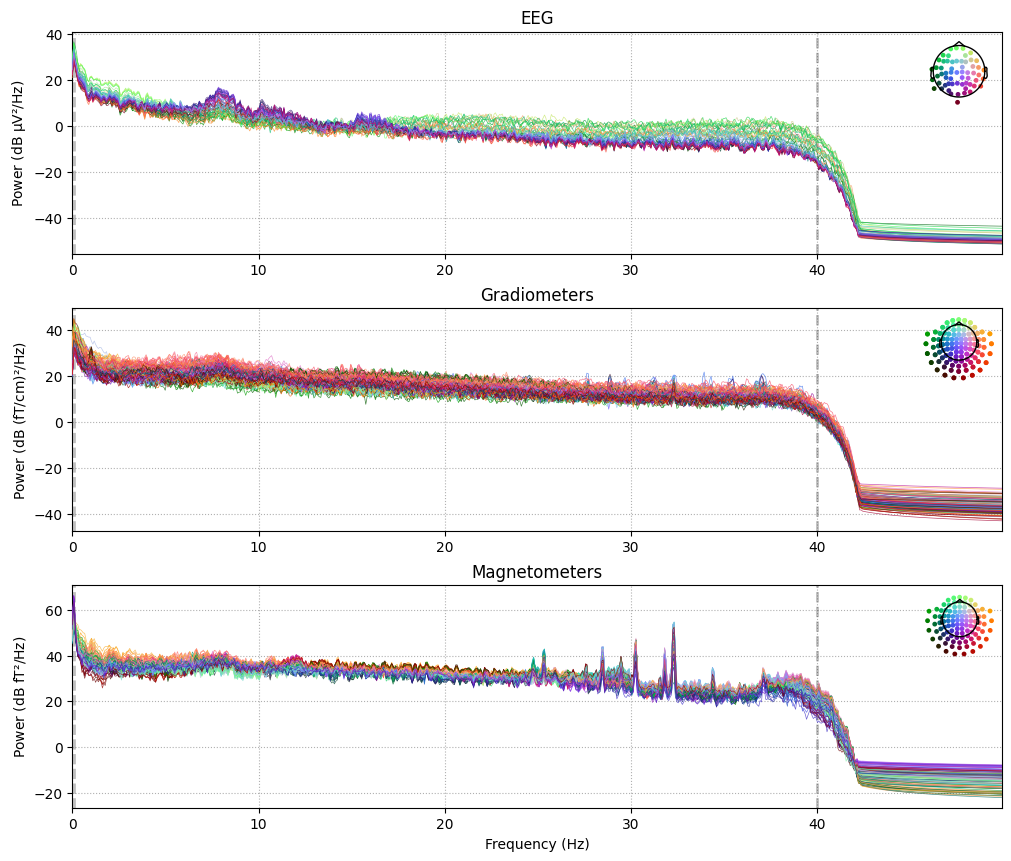

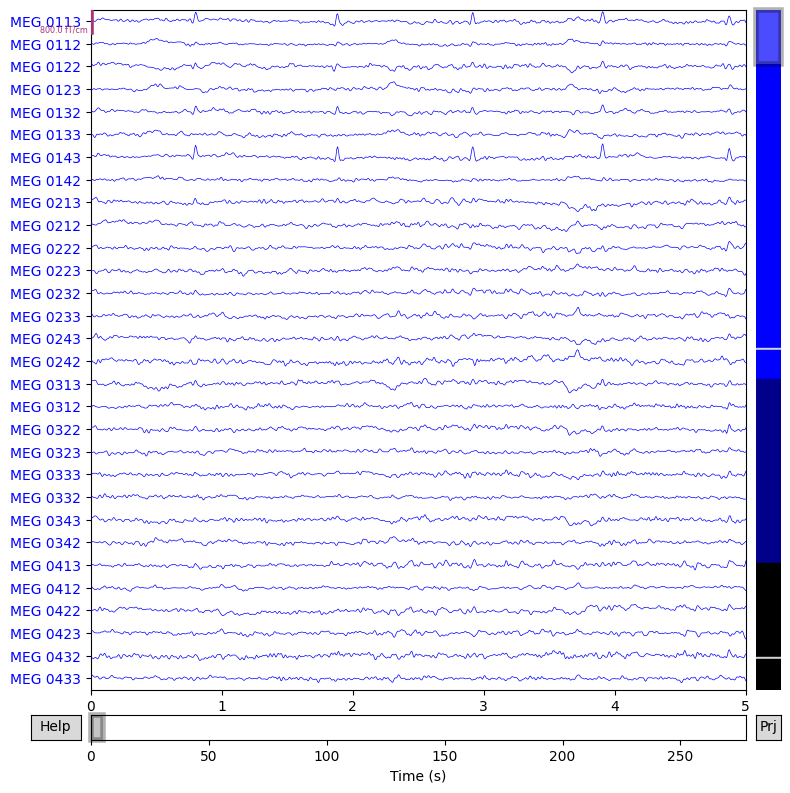

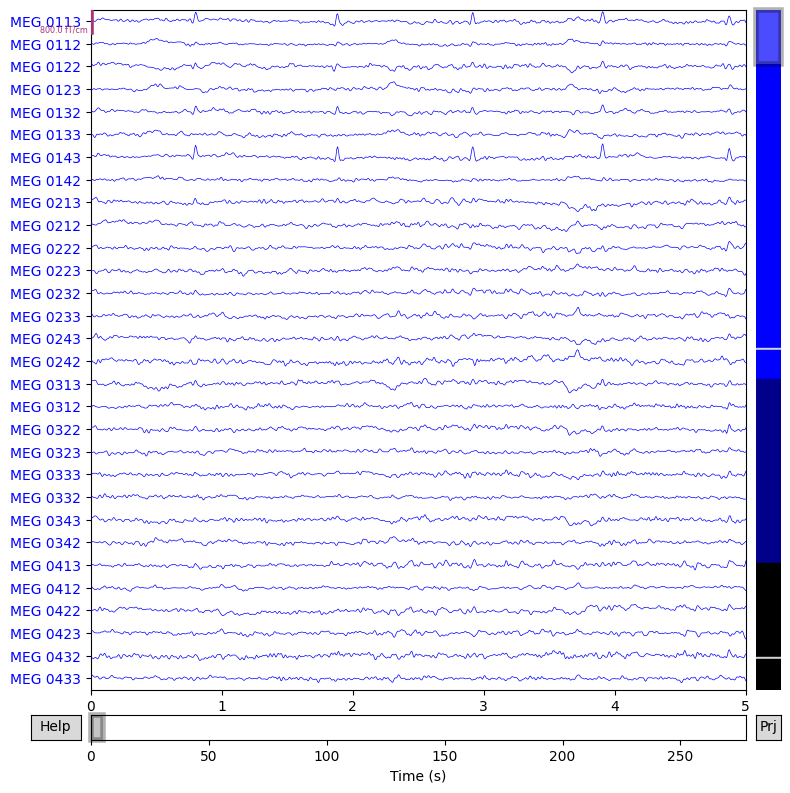

In [11]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

- Command Executed: The Python script appears to be executing a command that computes the Power Spectral Density (PSD) of EEG data. The method `raw.compute_psd()` is used to calculate the PSD with a specified maximum frequency (`fmax=50 Hz`) and then plots it using `.plot()`. The parameters suggest that the plot is being generated for selected data channels (`picks='data'`), excluding bad channels (`exclude='bads'`), without converting the power to decibels (`dB=False`), and without displaying amplitude (`amplitude=False`).
- Plot Duration and Channels: The `plot()` function is set to display a duration of 5 seconds of data across 30 channels. This is a subset of the total data available, likely chosen for a clear visual representation.
- Effective Window Size: The text "Effective window size : 13.639 (s)" indicates the length of the time window used to calculate each segment of the PSD. This window size affects the frequency resolution of the PSD.
- Power Spectral Density: The plot itself shows the Power Spectral Density (PSD) in decibels (dB) over the frequency range up to 50 Hz. Each line in the plot likely represents the PSD for one EEG channel, and the color variation helps differentiate between them. This visualization is used to assess the distribution of power across frequencies for the EEG signals.

## Power Spectral Density (PSD) in Decibels (dB)

The Power Spectral Density (PSD) represents how the power of a signal is distributed across various frequency components. When the PSD is expressed in decibels (dB), it indicates the logarithmic scale of power relative to a reference value. Converting power measurements to decibels is common in signal processing because it can make it easier to visualize changes across a wide range of power values.

Here's a more detailed explanation:

### Understanding the PSD

1. **Power of a Signal:** Power in this context refers to the average squared amplitude of the signal over time. For a signal `x(t)`, the power at time `t` is $x(t)^2$. When we talk about the power spectrum, we mean how this power is distributed across different frequency components.
2. **Frequency Components:** Every complex signal can be decomposed into a sum of simpler sinusoidal signals (sine and cosine functions) at various frequencies. This decomposition is done through a mathematical transformation known as the Fourier Transform. The power of each frequency component indicates how much of the signal's power is due to that frequency.
3. **Decibels (dB):** The decibel is a logarithmic unit that expresses the ratio of a value to a reference value. In the context of power, decibels are calculated using the formula:
     $$dB = 20 * \log_{10}(\frac{P}{P_{ref}})$$
     where `P` is the power of the frequency component, and $P_{ref}$ is the reference power level, often taken to be 1 milliwatt in audio applications but could be different in EEG applications. The factor of 20 arises from the fact that power is proportional to the square of the field quantity in many physical systems (like electrical systems where power is proportional to the square of voltage).
4. **PSD Plot:** A PSD plot with the vertical axis in decibels presents a logarithmic view of the power distribution. This is particularly useful when there are small variations in power at low frequencies and large variations at high frequencies; a logarithmic scale can represent both effectively. Frequencies are plotted on the horizontal axis, typically ranging from a few Hz to hundreds of Hz for EEG data.
5. **EEG Signal Analysis:** In EEG data analysis, the PSD can reveal important characteristics about brain activity. For instance, certain frequency bands (delta, theta, alpha, beta, and gamma) are known to be associated with different types of brain function. By analyzing the PSD, researchers can identify abnormal or distinctive patterns that might be linked to cognitive states or neurological conditions.

In the context of the image you provided, the PSD in dB over the frequency range up to 50 Hz would allow one to see which frequencies have more power and are hence more dominant in the EEG signal. This is crucial in identifying brain waves associated with different cognitive processes or pathologies.


## Preprocessing

MNE-Python supports a variety of preprocessing approaches and techniques
(maxwell filtering, signal-space projection, independent components analysis,
filtering, downsampling, etc); see the full list of capabilities in the
:mod:`mne.preprocessing` and :mod:`mne.filter` submodules. Here we'll clean
up our data by performing independent components analysis
(`~mne.preprocessing.ICA`); for brevity we'll skip the steps that helped us
determined which components best capture the **artifacts** (see
`tut-artifact-ica` for a detailed walk-through of that process).

Artifacts: In the context of MEG and other neuroimaging techniques, artifacts refer to extraneous signals or disturbances that are not related to the brain activity being measured but arise from other sources. These can potentially contaminate the data, making it harder to interpret the actual brain signals.


The following code is setting up and fitting an Independent Component Analysis (ICA) model to the data. Let's go through it step-by-step:

- `ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)`:
    - **mne.preprocessing.ICA** is a class that creates an ICA object.
    -  **n_components=20** specifies the number of components to extract from the data. This can be thought of as the number of underlying signals or sources that the algorithm will attempt to discover.
    - **random_state=97** sets the seed for the random number generator used by the algorithm, ensuring reproducibility of the results.
    - **max_iter=800** defines the maximum number of iterations the algorithm should run to find the components.
- `ica.fit(raw)`: fit is a method applied to the ICA object to fit the ICA model to the raw data. This process involves the algorithm learning the weights that can project the input data onto the independent components.
- `ica.exclude = [1, 2]`: After fitting, components that are identified as artifacts (like eye blinks or heartbeats) or noise are typically excluded from further analysis. This line is manually setting the first and second components (indexed as 1 and 2) to be excluded. The comment mentions that the rationale for picking these specific components is omitted, suggesting there was some prior analysis or reasoning that identified them as unwanted.
- `ica.plot_properties(raw, picks=ica.exclude)`:
    - This method is used to visualize the properties of the ICA components that have been marked for exclusion. The plot_properties function generates plots that may include the time series of the ICA component, its topography (the spatial distribution of the component across the sensors), the component's spectrum, and its relationship to other components, among other information.
    - **raw** is the raw data object that contains the data being analyzed.
    - **picks=ica.exclude** instructs the plotting function to only display the properties of the components listed in ica.exclude


Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 88.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


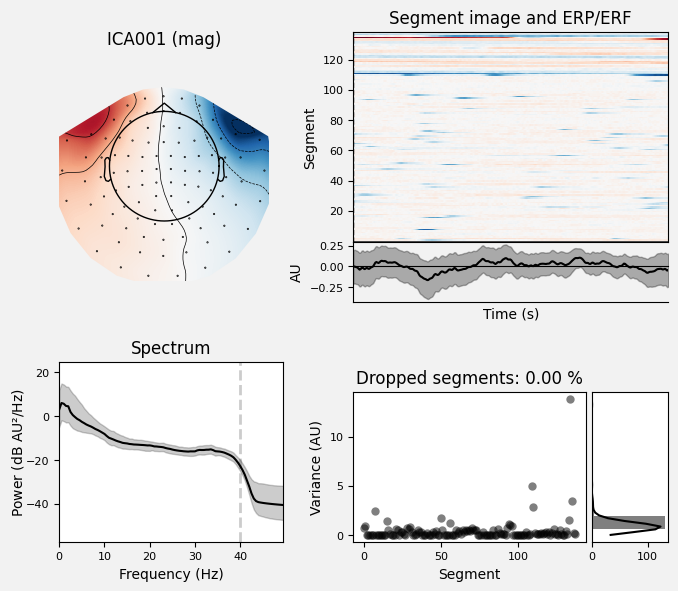

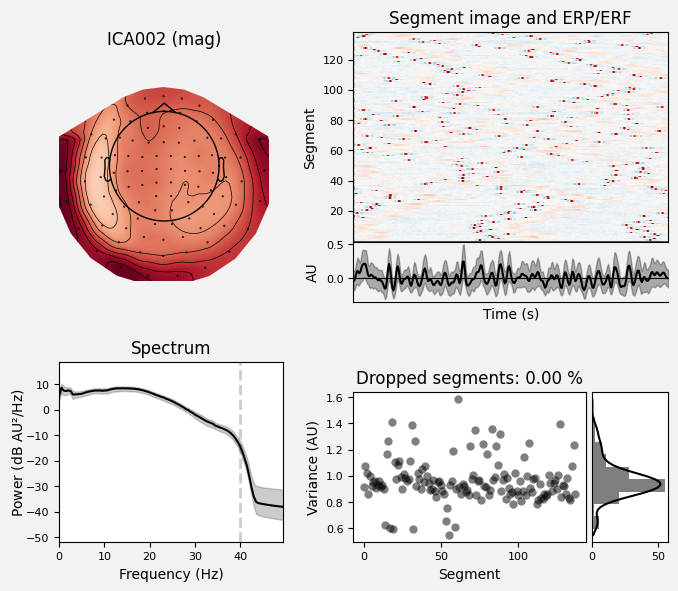

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [13]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

For the first four graph:
- Top Left - Topographic Map (ICA Component): This shows an Independent Component Analysis (ICA) component labeled "ICA001 (mag)", presumably representing magnetic fields as it's common in MEG. The topographic map displays the distribution of magnetic field magnitudes across the scalp, with red indicating areas of higher magnitude and blue indicating lower magnitude. ICA is used to separate out signals that are statistically independent from each other, often to remove artifacts from brain signals.
    - In the context of magnetoencephalography (MEG) or electroencephalography (EEG), each dot represents the location of a sensor used to measure magnetic fields or electrical activity at different places on the scalp.
    - The big circle in the middle of the graph represents the head, with the nose typically at the top center, providing an outline of where the sensors are placed relative to head anatomy. This circular representation is a common convention in EEG and MEG, and it helps in visualizing which areas of the brain might be involved according to the sensor locations.
    - The transition between these two areas, where the colors change, indeed marks the margin or boundary between the areas of high and low magnitudes. This visualization helps researchers to see which regions of the brain might be more active or involved in the process being measured, according to the ICA component's distribution.
- Top Right - Segment Image and ERP/ERF: This is a combination of two related visualizations. The top part, with the blue and red lines, is likely a representation of many individual segments of MEG/EEG data, possibly time-locked to a specific event (event-related fields [ERFs] in MEG or event-related potentials [ERPs] in EEG). Each horizontal line could represent a single trial or segment, and the color might indicate the strength and direction of the magnetic field or electrical potential. Below this is a black line graph that seems to be the average across all segments (average ERF/ERP), showing how the field/potential changes over time. The shaded area around the average line may indicate standard deviation or confidence interval.
- Bottom Left - Spectrum: This graph shows the power spectral density of the signal across different frequencies, often used to analyze the frequency domain characteristics of the brain signals. The X-axis is frequency in Hertz (Hz), and the Y-axis is power in decibels per Hertz (dB/Hz). The black line represents the average spectrum, and the shaded area indicates variation across segments or trials. The dashed vertical lines might mark specific frequencies of interest, such as alpha (8-12 Hz), beta (13-30 Hz), etc.
- Bottom Right - Variance and Dropped Segments: The main plot here shows the variance of each segment, which can help in detecting outliers or noisy trials. If a segment has a very high or very low variance, it might be indicative of artifact or noise and thus could be dropped (excluded from analysis). The subplot on the right shows the distribution of variances across segments, helping to visualize the spread and detect any segments that are significantly different from the others. The "Dropped segments: 0.00%" indicates that no segments were excluded based on this criterion, which is ideal as it suggests data quality was consistently good across all segments.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


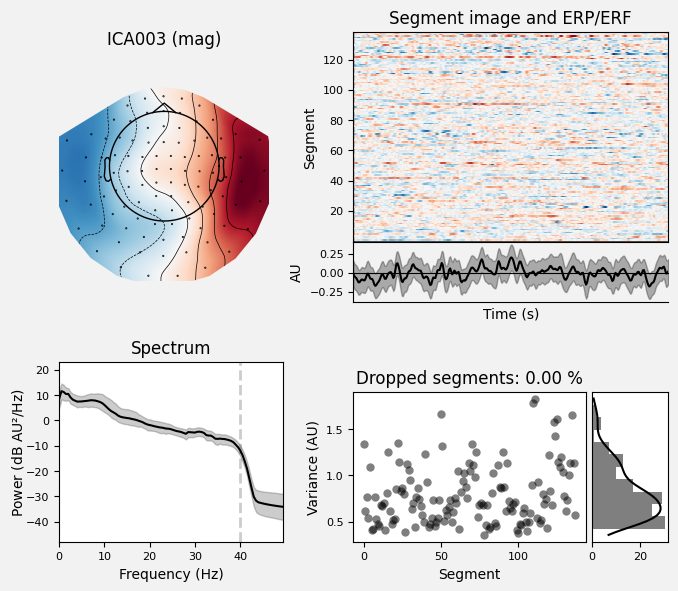

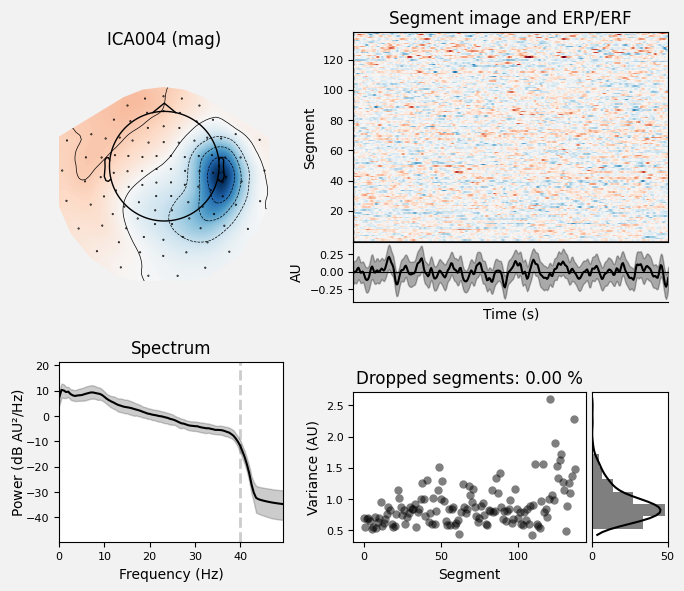

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [14]:
ica.plot_properties(raw, picks=[3, 4])

Once we're confident about which component(s) we want to remove, we pass them
as the ``exclude`` parameter and then apply the ICA to the raw signal. The
`~mne.preprocessing.ICA.apply` method requires the raw data to be loaded into
memory (by default it's only read from disk as-needed), so we'll use
`~mne.io.Raw.load_data` first. We'll also make a copy of the `~mne.io.Raw`
object so we can compare the signal before and after artifact removal
side-by-side:



Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


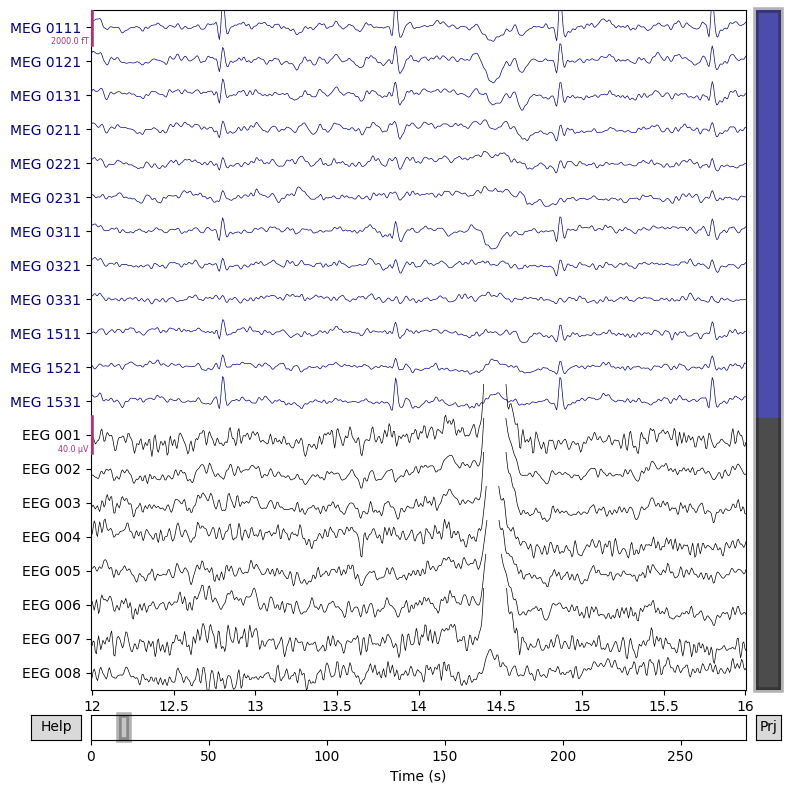

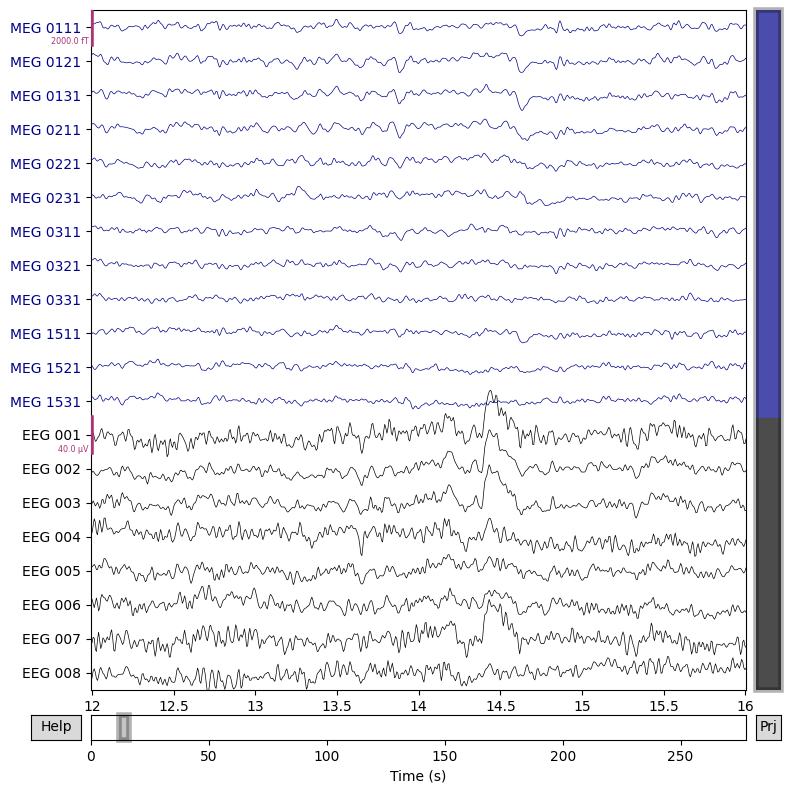

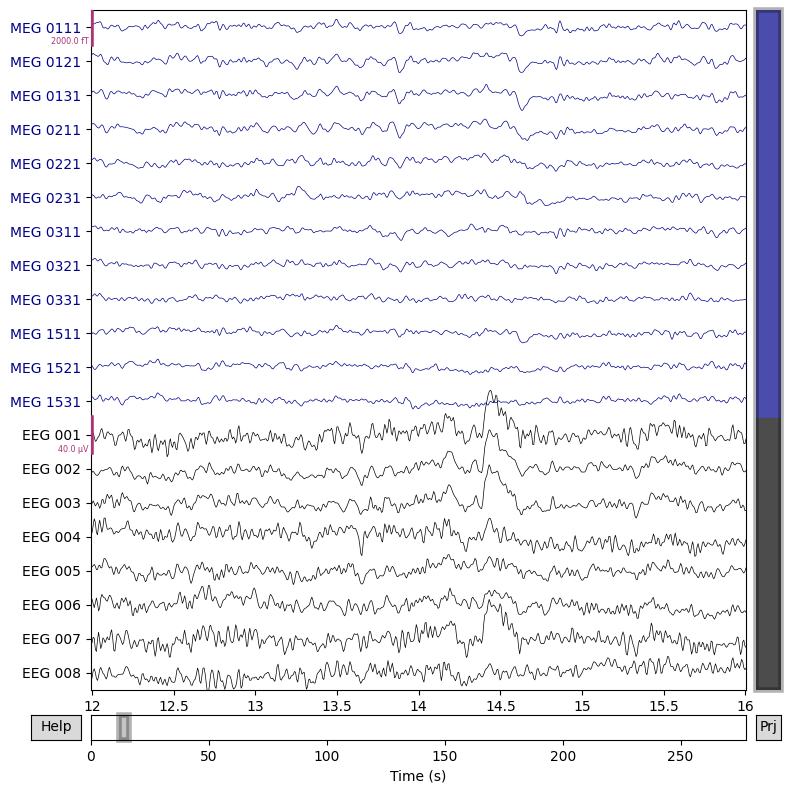

In [15]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)


## Detecting experimental events

The sample dataset includes several :term:`"STIM" channels <stim channel>`
that recorded electrical signals sent from the stimulus delivery computer (as
brief DC shifts / squarewave pulses). These pulses (often called "triggers")
are used in this dataset to mark experimental events: stimulus onset,
stimulus type, and participant response (button press). The individual STIM
channels are combined onto a single channel, in such a way that voltage
levels on that channel can be unambiguously decoded as a particular event
type. On older Neuromag systems (such as that used to record the sample data)
this summation channel was called ``STI 014``, so we can pass that channel
name to the `mne.find_events` function to recover the timing and identity of
the stimulus events.



In [16]:
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])  # show the first 5

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


The resulting events array is an ordinary 3-column :class:`NumPy array
<numpy.ndarray>`, with sample number in the first column and integer event ID
in the last column; the middle column is usually ignored. Rather than keeping
track of integer event IDs, we can provide an *event dictionary* that maps
the integer IDs to experimental conditions or events. In this dataset, the
mapping looks like this:


+----------+----------------------------------------------------------+
| Event ID | Condition                                                |
+==========+==========================================================+
| 1        | auditory stimulus (tone) to the left ear                 |
+----------+----------------------------------------------------------+
| 2        | auditory stimulus (tone) to the right ear                |
+----------+----------------------------------------------------------+
| 3        | visual stimulus (checkerboard) to the left visual field  |
+----------+----------------------------------------------------------+
| 4        | visual stimulus (checkerboard) to the right visual field |
+----------+----------------------------------------------------------+
| 5        | smiley face (catch trial)                                |
+----------+----------------------------------------------------------+
| 32       | subject button press                                     |
+----------+----------------------------------------------------------+



In [17]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

Event dictionaries like this one are used when extracting epochs from
continuous data; the ``/`` character in the dictionary keys allows pooling
across conditions by requesting partial condition descriptors (i.e.,
requesting ``'auditory'`` will select all epochs with Event IDs 1 and 2;
requesting ``'left'`` will select all epochs with Event IDs 1 and 3). An
example of this is shown in the next section. There is also a convenient
`~mne.viz.plot_events` function for visualizing the distribution of events
across the duration of the recording (to make sure event detection worked as
expected). Here we'll also make use of the `~mne.Info` attribute to get the
sampling frequency of the recording (so our x-axis will be in seconds instead
of in samples).



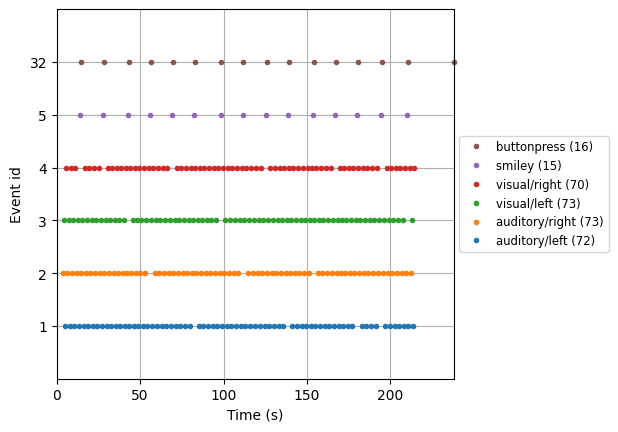

In [18]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

For paradigms that are not event-related (e.g., analysis of resting-state
data), you can extract regularly spaced (possibly overlapping) spans of data
by creating events using `mne.make_fixed_length_events` and then proceeding
with epoching as described in the next section.



## Epoching continuous data

The `~mne.io.Raw` object and the events array are the bare minimum needed to
create an `~mne.Epochs` object, which we create with the `~mne.Epochs` class
constructor. Here we'll also specify some data quality constraints: we'll
reject any epoch where peak-to-peak signal amplitude is beyond reasonable
limits for that channel type. This is done with a *rejection dictionary*; you
may include or omit thresholds for any of the channel types present in your
data. The values given here are reasonable for this particular dataset, but
may need to be adapted for different hardware or recording conditions. For a
more automated approach, consider using the `autoreject package`_.



In [19]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

We'll also pass the event dictionary as the ``event_id`` parameter (so we can
work with easy-to-pool event labels instead of the integer event IDs), and
specify ``tmin`` and ``tmax`` (the time relative to each event at which to
start and end each epoch). As mentioned above, by default `~mne.io.Raw` and
`~mne.Epochs` data aren't loaded into memory (they're accessed from disk only
when needed), but here we'll force loading into memory using the
``preload=True`` parameter so that we can see the results of the rejection
criteria being applied:



In [20]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


Next we'll pool across left/right stimulus presentations so we can compare
auditory versus visual responses. To avoid biasing our signals to the left or
right, we'll use `~mne.Epochs.equalize_event_counts` first to randomly sample
epochs from each condition to match the number of epochs present in the
condition with the fewest good epochs.



In [21]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Like `~mne.io.Raw` objects, `~mne.Epochs` objects also have a number of
built-in plotting methods. One is `~mne.Epochs.plot_image`, which shows each
epoch as one row of an image map, with color representing signal magnitude;
the average evoked response and the sensor location are shown below the
image:



Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


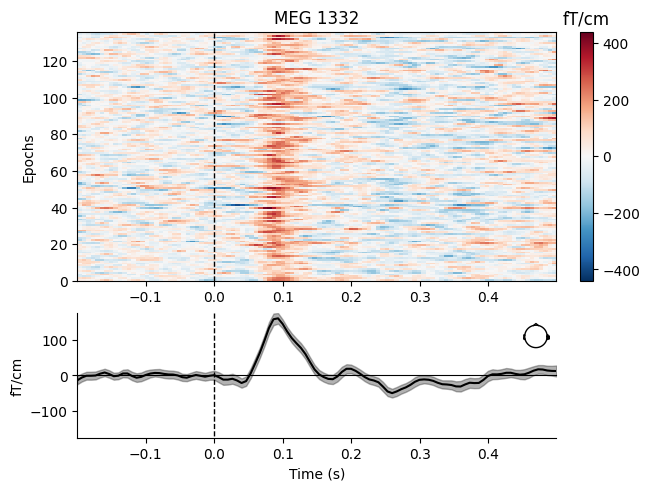

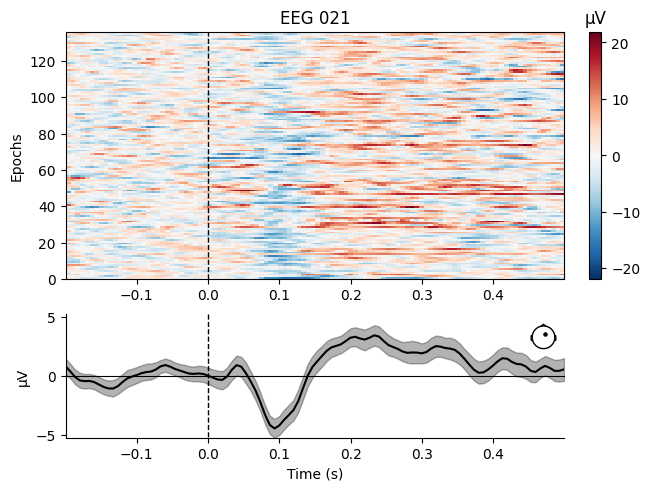

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [22]:
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

<div class="alert alert-info"><h4>Note</h4><p>Both `~mne.io.Raw` and `~mne.Epochs` objects have `~mne.Epochs.get_data`
    methods that return the underlying data as a
    :class:`NumPy array <numpy.ndarray>`. Both methods have a ``picks``
    parameter for subselecting which channel(s) to return; ``raw.get_data()``
    has additional parameters for restricting the time domain. The resulting
    matrices have dimension ``(n_channels, n_times)`` for `~mne.io.Raw` and
    ``(n_epochs, n_channels, n_times)`` for `~mne.Epochs`.</p></div>

## Time-frequency analysis

The :mod:`mne.time_frequency` submodule provides implementations of several
algorithms to compute time-frequency representations, power spectral density,
and cross-spectral density. Here, for example, we'll compute for the auditory
epochs the induced power at different frequencies and times, using Morlet
wavelets. On this dataset the result is not especially informative (it just
shows the evoked "auditory N100" response); see `here
<inter-trial-coherence>` for a more extended example on a dataset with richer
frequency content.



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.3s


No baseline correction applied


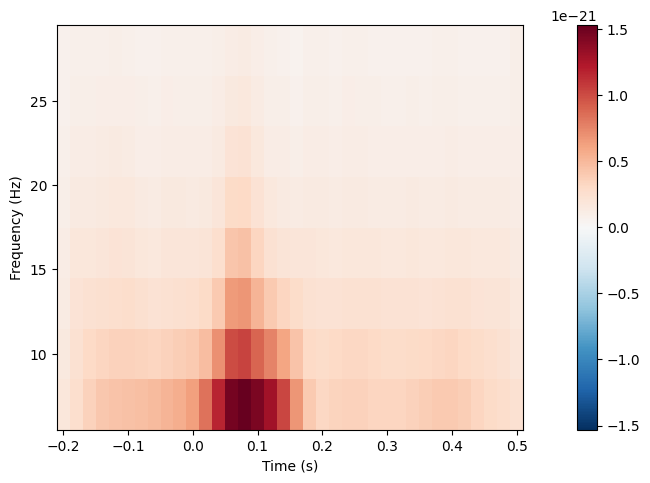

[<Figure size 640x480 with 2 Axes>]

In [23]:
frequencies = np.arange(7, 30, 3)
power = aud_epochs.compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot(["MEG 1332"])

## Estimating evoked responses

Now that we have our conditions in ``aud_epochs`` and ``vis_epochs``, we can
get an estimate of evoked responses to auditory versus visual stimuli by
averaging together the epochs in each condition. This is as simple as calling
the `~mne.Epochs.average` method on the `~mne.Epochs` object, and then using
a function from the :mod:`mne.viz` module to compare the global field power
for each sensor type of the two `~mne.Evoked` objects:



Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


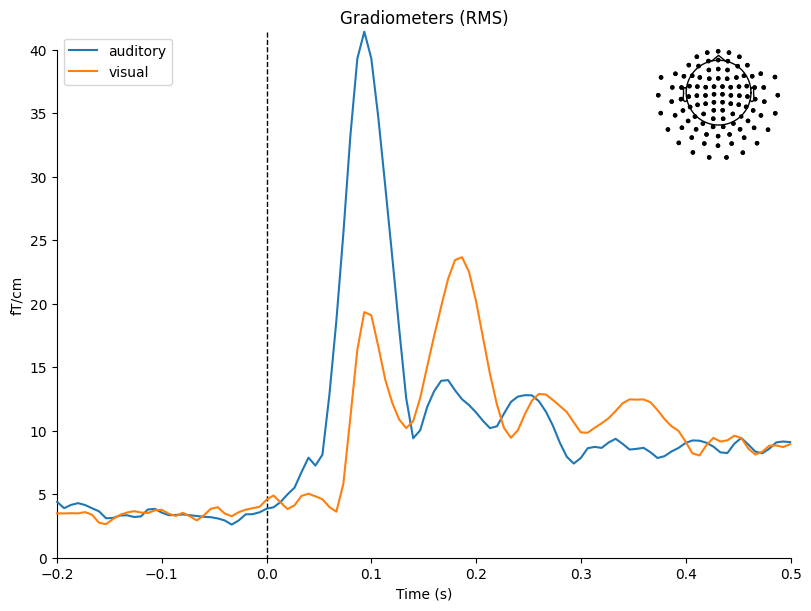

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


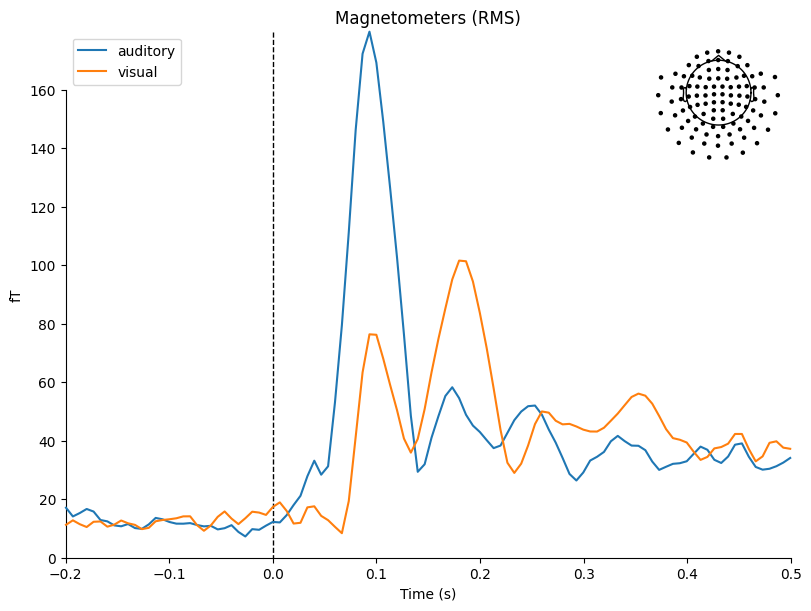

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


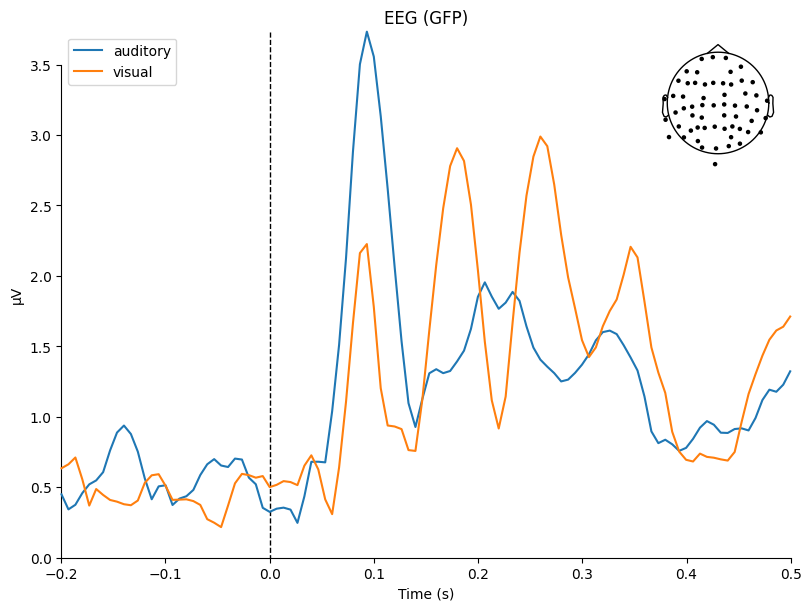

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [24]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)

We can also get a more detailed view of each `~mne.Evoked` object using other
plotting methods such as `~mne.Evoked.plot_joint` or
`~mne.Evoked.plot_topomap`. Here we'll examine just the EEG channels, and see
the classic auditory evoked N100-P200 pattern over dorso-frontal electrodes,
then plot scalp topographies at some additional arbitrary times:



Projections have already been applied. Setting proj attribute to True.


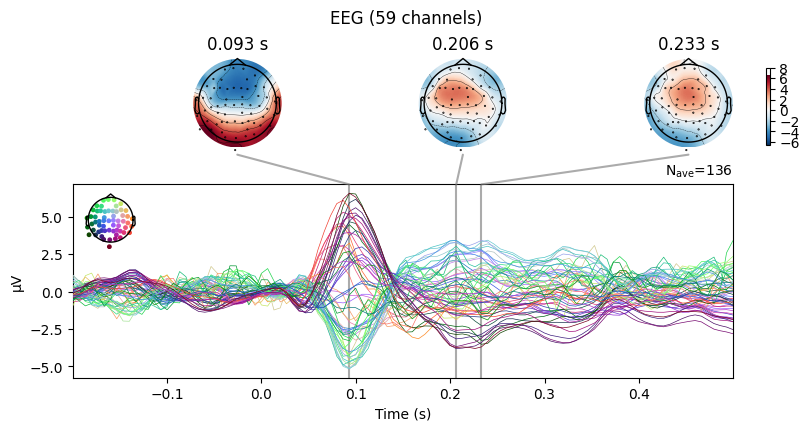

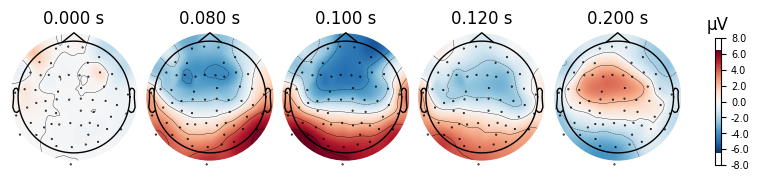

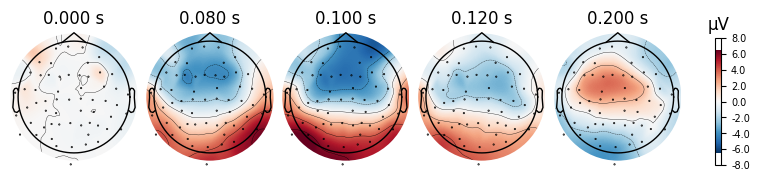

In [25]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

Evoked objects can also be combined to show contrasts between conditions,
using the `mne.combine_evoked` function. A simple difference can be
generated by passing ``weights=[1, -1]``. We'll then plot the difference wave
at each sensor using `~mne.Evoked.plot_topo`:



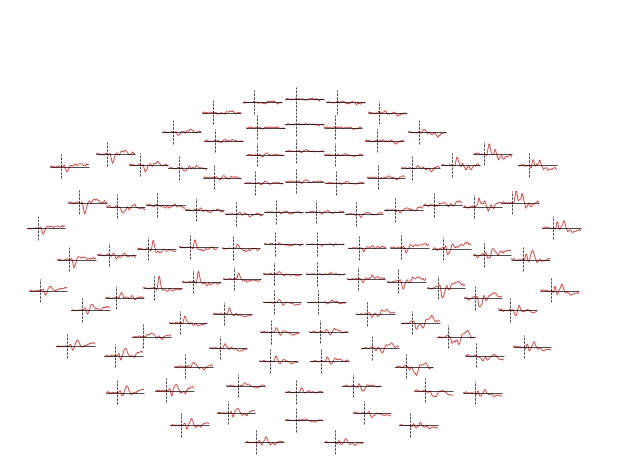

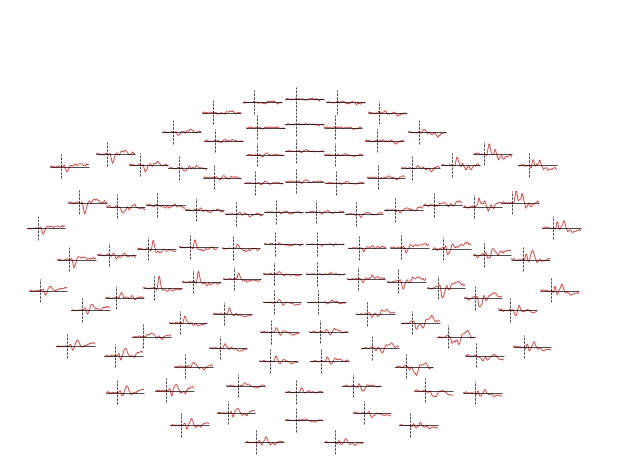

In [26]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

## Inverse modeling

Finally, we can estimate the origins of the evoked activity by projecting the
sensor data into this subject's :term:`source space` (a set of points either
on the cortical surface or within the cortical volume of that subject, as
estimated by structural MRI scans). MNE-Python supports lots of ways of doing
this (dynamic statistical parametric mapping, dipole fitting, beamformers,
etc.); here we'll use minimum-norm estimation (MNE) to generate a continuous
map of activation constrained to the cortical surface. MNE uses a linear
:term:`inverse operator` to project EEG+MEG sensor measurements into the
source space. The inverse operator is computed from the
:term:`forward solution` for this subject and an estimate of `the
covariance of sensor measurements <tut-compute-covariance>`. For this
tutorial we'll skip those computational steps and load a pre-computed inverse
operator from disk (it's included with the `sample data
<sample-dataset>`). Because this "inverse problem" is underdetermined (there
is no unique solution), here we further constrain the solution by providing a
regularization parameter specifying the relative smoothness of the current
estimates in terms of a signal-to-noise ratio (where "noise" here is akin to
baseline activity level across all of cortex).



In [35]:
# load inverse operator
inverse_operator_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(
    vis_evoked, inv_operator, lambda2=lambda2, method="MNE"
)  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from /EEG_tut/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistic

Finally, in order to plot the source estimate on the subject's cortical
surface we'll also need the path to the sample subject's structural MRI files
(the ``subjects_dir``):



In [45]:
import ipyevents


In [57]:
import nibabel


Using control points [ 5.17909658  6.18448887 18.83197989]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /EEG_tut/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


/tmp/ipykernel_297/2284992275.py:16: RuntimeWarning: 636/155407 vertices not included in smoothing, consider increasing the number of steps
  stc.plot(initial_time=0.1, hemi="lh", views=view, subjects_dir=subjects_dir, backend='matplotlib')


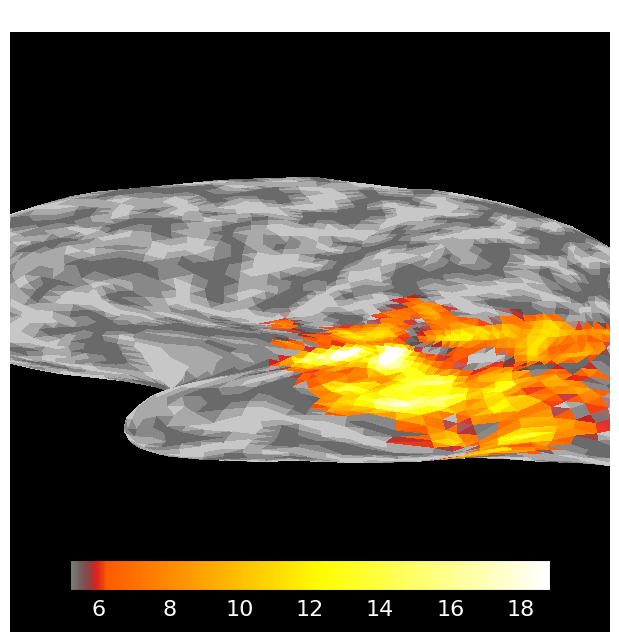

Using control points [ 5.17909658  6.18448887 18.83197989]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /EEG_tut/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


/tmp/ipykernel_297/2284992275.py:16: RuntimeWarning: 636/155407 vertices not included in smoothing, consider increasing the number of steps
  stc.plot(initial_time=0.1, hemi="lh", views=view, subjects_dir=subjects_dir, backend='matplotlib')


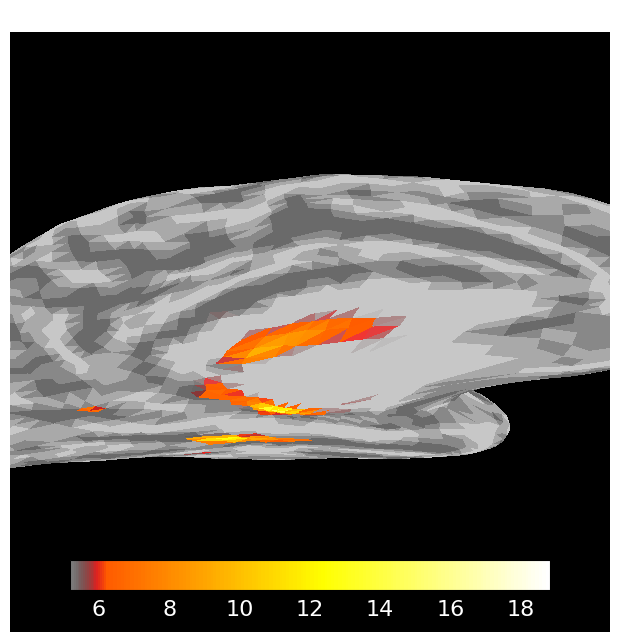

In [60]:
import mne
from pathlib import Path

# Load sample data (replace this with your own data loading code)
data_path = mne.datasets.sample.data_path()
stc_fname = Path(data_path).joinpath('MEG', 'sample', 'sample_audvis-meg-eeg')

# Read the source estimate data
stc = mne.read_source_estimate(stc_fname, subject='sample')

# Path to subjects' MRI files
subjects_dir = Path(data_path).joinpath('subjects')

# Plot the STC using matplotlib backend for each view separately
for view in ["lat", "med"]:
    stc.plot(initial_time=0.1, hemi="lh", views=view, subjects_dir=subjects_dir, backend='matplotlib')


The remaining tutorials have *much more detail* on each of these topics (as
well as many other capabilities of MNE-Python not mentioned here:
connectivity analysis, encoding/decoding models, lots more visualization
options, etc). Read on to learn more!

.. LINKS


